# Case study summary 
This document compares MC (Muskingum-Cunge) computed values in WRF-HYDRO against those from a Python routing tool. The Python routing tool consists of NHD traversal tools (i.e., nhd_network_traversal.py, nhd_network_utilities.py, nhd_reach_utilities.py, compute_nhd_routing_v2.py) and MC standalone tools (i.e., channel_routing_tools.py, MCsingleSegStime_f2py_noIC_clean.f90, and varSingleSegStime_f2py_noIC_clean.f90) 

# 1. Purpose
This case study investigates whether or not MC source code carved out of WRF-HYDRO and then transformed into a Python extension module generates the same results as WRF-HYDRO.

# 2. Study Area
Pocono Basin where the Lehigh River in PL flows through was chosen mainly because WRF-HYDRO was applied to this basin by Austin Raney and thus its MC-computed results are readily available including lateral inflows.  Out of the entire applied segments marked by 374 red circles in Figure 1, 54 segments, marked by green circles, were chosen for this study mainly because this sub-NHD has no reservoirs and all of its segments have computed flow and depth values by MC of WRF-HYDRO.

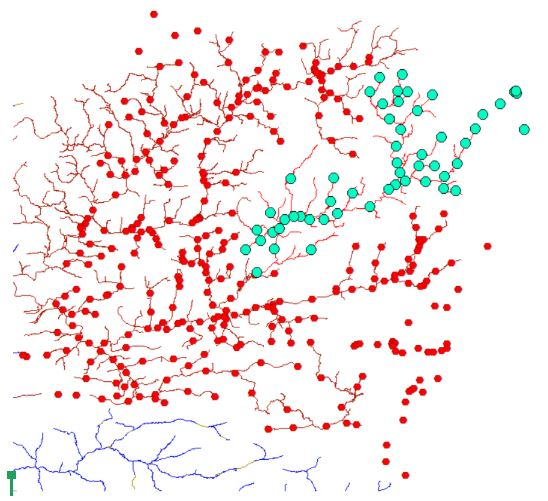
Figure 1. Study area

# 3. Method and Results
With 300 sec time interval and 12 hrs total time period, total 144 time steps were used in this study.  Overall relative errors in flow as well as depth are less than 0.05% or 0.0005, which is safely to be considered to be identical, factoring in primarily propagation of rounding errors differently occurring in the two model platforms. 

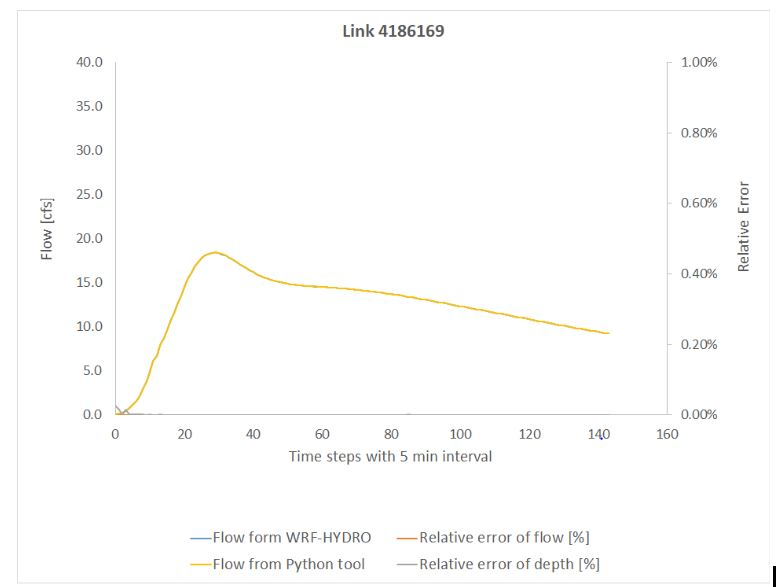
Figure 2. Flow computed in WRF-HYDRO and relative errors computed between WRF-HYDRO and the Python routing tool.   Link 4186169 is used for Figure 2, as indicated in Figure 4.  The two relative error graphs don’t appear here because they are simply zeros.

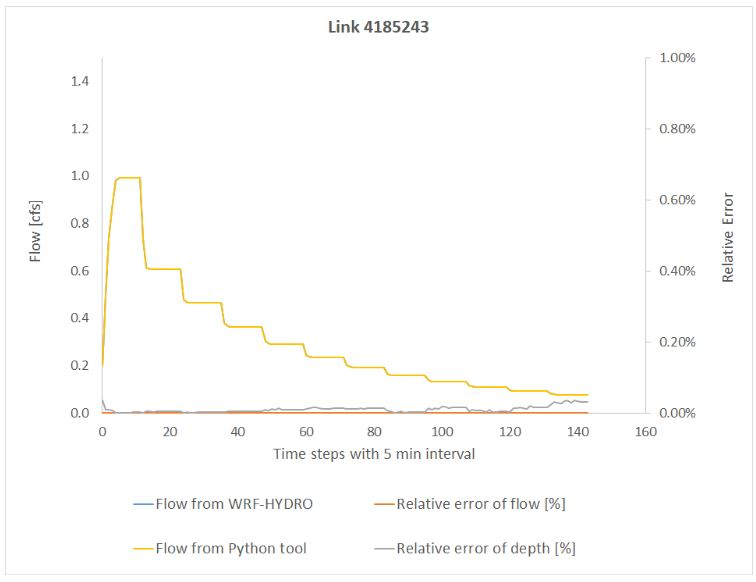
Figure 3. Flow computed in WRF-HYDRO and relative errors computed between WRF-HYDRO and the Python routing tool.   Link 4185243 is used for Figure 2, as indicated in Figure 4.

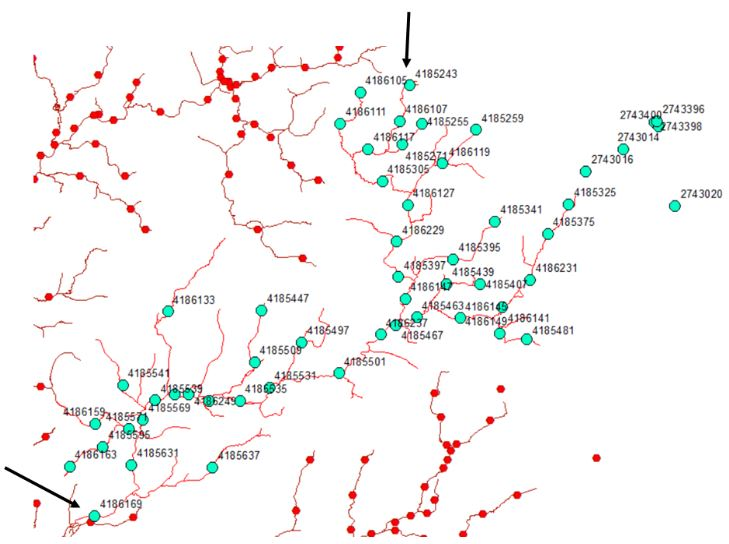
Figure 4. Study basin area with all the segment ID represented by its link number.


In [ ]:
## Basic imports
import sys
import os
import time

# WARNING: These global declarations cause the parallel implementation to 
# crash when executed on Windows
connections = None
networks = None
flowdepthvel = None

from sys import platform
if platform == "linux" or platform == "linux2":
    pass
elif platform == "darwin":
    pass
elif platform == "win32":
    print('The parallel version of compute_nhd_routing.py will not execute as currently')
    print('written due to the lack of a fork() capability in the windows OS.')
    print('For parallel execution, please us a *nix OS.')
    print('\nexiting...')
    sys.exit()
    # Some useful references:
    # https://stackoverflow.com/questions/985281/what-is-the-closest-thing-windows-has-to-fork/985525#985525
    # https://stackoverflow.com/questions/8220108/how-do-i-check-the-operating-system-in-python
    # https://stackoverflow.com/questions/6596617/python-multiprocess-diff-between-windows-and-linux

ENV_IS_CL = False
if ENV_IS_CL: root = '/content/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/'
elif not ENV_IS_CL: 
    sys.setrecursionlimit(4000)
#     root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    root = os.path.dirname(os.path.dirname(os.path.abspath('')))
    sys.path.append(os.path.join(root, r'src', r'python_framework'))
    sys.path.append(os.path.join(root, r'src', r'python_routing')) #by Dong Ha
    fortran_source_dir = os.path.join(root, r'src', r'fortran_routing', r'mc_pylink_v00', r'MC_singleSeg_singleTS')
    sys.path.append(fortran_source_dir)

## F2PY Muskingum Cunge module
mc_f2py= True
if mc_f2py:
    try:
        import subprocess

        f2py_call = []
        f2py_call.append(r'f2py3')
        f2py_call.append(r'-c')
        f2py_call.append(r'varSingleSegStime_f2py_noIC_clean.f90')
        f2py_call.append(r'MCsingleSegStime_f2py_noIC_clean.f90')
        f2py_call.append(r'-m')
        f2py_call.append(r'mc_sseg_stime_noIC')
        subprocess.run(f2py_call, cwd=r'../fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS',
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except Exception as e:
        print(e)

## network and reach utilities
import nhd_network_utilities as nnu
import nhd_reach_utilities as nru
import channel_routing_tools as crt

## Muskingum Cunge
import numpy as np

def mc_route_network(
          terminal_segment = None
        , network = None
        , supernetwork_data = None
        , outputpath = "."
        , nts = None
        , dt_mc= None
        , latflow= None
#         , connections = None
        , verbose = False
        , debuglevel = 0
        ):

    global connections
    global flowdepthvel 

    if verbose: print(f"Executing simulation on network {terminal_segment} beginning with streams of order {network['maximum_reach_seqorder']}")

    ##------------------------------------------------------------------------
    ## Compute ordered_reaches and last_segment_reach for all the segments of
    ## reach referenced by head_segment
    ##------------------------------------------------------------------------
    ordered_reaches = {}
    # Start: By Dong Ha
    last_segment_reach={}
    #End    
    for head_segment, reach in network['reaches'].items():
        if reach['seqorder'] not in ordered_reaches:
            ordered_reaches.update({reach['seqorder']:[]}) #TODO: Should this be a set/dictionary?
        ordered_reaches[reach['seqorder']].append([head_segment, reach])
        # Start: By Dong Ha
        seg_list=list(reach['segments_list'])
        lastseg=seg_list[0]
        last_segment_reach[head_segment]= lastseg
        # End 

    ##-------------------------------------------
    ## From jorder= maximum_reach_order to zero
    ##     From each reach that has jorder
    ##         run mc routing of a chosen scheme
    ##
    ## Output-> flowdepthvel
    ##--------------------------------------------
    #Note that not networks but network that takes networks values corresponding to 'terminal_segment' keys.
    #Also, network here takes 'terminal_segment' key only at the lower end of a network.      
    for x in range(network['maximum_reach_seqorder'],-1,-1):    
        
        for head_segment, reach in ordered_reaches[x]:       
#             print(latflow)
            ## START: run MC over each segment over entire timesteps
            crt.mc_tlp_over_seg(
                            connections= connections 
                            ,supernetwork_data= supernetwork_data
                            ,reach= reach
                            ,last_segment_reach= last_segment_reach
                            ,nts= nts
                            ,dt_mc= dt_mc
                            ,latflow= latflow
                            ,flowdepthvel= flowdepthvel
                            )            
            ## END: MC-computed results for flow, vel, and depth are stored in 'flowdepthvel'
           
            ## Start: Only for printing results
            seg_list=list(reach['segments_list'])
            seg_list=seg_list[::-1] #to reversed order
            ncomp= len(reach['segments_list'])
            for seg in range(0,ncomp):  
                segID= seg_list[seg]
                for ts in range (0,nts):
                    print(f"ts {ts} head_segment {head_segment} segINDEX {seg} segID {segID} \
                            FNL:ql qdc vel depth {flowdepthvel[segID]['qlat'][ts]} {flowdepthvel[segID]['flow'][ts]} \
                            {flowdepthvel[segID]['vel'][ts]} {flowdepthvel[segID]['depth'][ts]}")  
            with open(os.path.join(outputpath,r"flowdepthvel.txt"),"a") as mc_result:
                for seg in range(0,ncomp):  
                    segID= seg_list[seg]
                    for ts in range (0,nts):
                        mc_result.write("%s %s %s %s %s %s\n" % (ts, segID, flowdepthvel[segID]['qlat'][ts], 
                            flowdepthvel[segID]['flow'][ts], flowdepthvel[segID]['vel'][ts], flowdepthvel[segID]['depth'][ts]))        
              ## End  
                          
def main():

    global connections
    global networks
    global flowdepthvel

    verbose = True
    debuglevel = 0
    showtiming = True

    test_folder = os.path.join(root, r'test')
    geo_input_folder = os.path.join(test_folder, r'input', r'geo')

    #TODO: Make these commandline args
#     supernetwork= 'Pocono_TEST1'
    supernetwork= 'Pocono_TEST2'
    """##NHD Subset (Brazos/Lower Colorado)"""
#     supernetwork = 'Brazos_LowerColorado_ge5'
    """##NHD CONUS order 5 and greater"""
    # supernetwork = 'CONUS_ge5'
    """These are large -- be careful"""
#     supernetwork = 'Mainstems_CONUS'
    # supernetwork = 'CONUS_FULL_RES_v20'
    # supernetwork = 'CONUS_Named_Streams' #create a subset of the full resolution by reading the GNIS field
    # supernetwork = 'CONUS_Named_combined' #process the Named streams through the Full-Res paths to join the many hanging reaches

    if verbose: print('creating supernetwork connections set')
    if showtiming: start_time = time.time()
    #STEP 1
    supernetwork_data, supernetwork_values = nnu.set_networks(
        supernetwork = supernetwork
        , geo_input_folder = geo_input_folder
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        )
    if verbose: print('supernetwork connections set complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))

    #STEP 2
    if showtiming: start_time = time.time()
    if verbose: print('organizing connections into networks and reaches ...')
    networks = nru.compose_networks(
        supernetwork_values
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        , showtiming = showtiming
        )
    if verbose: print('reach organization complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))
    

    #STEP 3: Route NHD streamflow
    if showtiming: start_time = time.time()
    executiontype = 'serial' # 'parallel'

    if verbose: print('executing serial computation on ordered reaches ...')
    connections = supernetwork_values[0]

    nts = 144  # number fof timestep = 1140 * 60(model timestep) = 86400 = day
    dt_mc= 300.0 # time interval for MC
    
    # Lateral flow
    ## test 1. Take lateral flow from wrf-hydro output from Pocono Basin
    qlcol=54
    qlrow=145
    ql=np.zeros((qlrow,qlcol))
    ql_input_folder= '../../test/input/geo/Channels/PoconoSampleData2/Pocono_ql_testsamp1_nwm_mc.txt' 
    print(ql_input_folder)
    for j in range(0, qlcol):
        ql[0,j]=np.loadtxt(ql_input_folder, max_rows=1,usecols=(j+2)) 
        ql[1:,j]=np.loadtxt(ql_input_folder, skiprows=2,usecols=(j+2))
    latflow={}
    for j in range(0,qlcol):
        latflow.update({ql[0,j]:{'lateralflow':ql[1:,j]}})
       
    flowdepthvel = {connection:{'flow':np.zeros(nts)
                                , 'depth':np.zeros(nts)
                                , 'vel':np.zeros(nts)
                                , 'qlat':np.zeros(nts)}
                               for connection in connections}  

    if executiontype == 'serial':
        iter=0
        for terminal_segment, network in networks.items():
            if showtiming: network_start_time = time.time()
#             iter=iter+1
#             print(f"terminal_segment iter-> {iter}")

            ## run MC to route network 
            mc_route_network(
                  terminal_segment = terminal_segment
                , network = network
                , supernetwork_data = supernetwork_data
                , outputpath = os.path.join(root, r"test", r"output", r"text")
                , nts = nts
                , dt_mc= dt_mc
                , latflow= latflow                
#         , connections = None
                , verbose = False
                , debuglevel = 0
            )
        
#             if verbose: print(f'{terminal_segment} completed')
#             if showtiming: print("... in %s seconds." % (time.time() - network_start_time))
        
#     if verbose: print('ordered reach computation complete')
#     if showtiming: print("... in %s seconds." % (time.time() - start_time))

if __name__ == '__main__':
    main()
